#Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#Importing Dataset

In [30]:
df = pd.read_csv("Fraud.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [31]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#Data Cleaning

In [32]:
df.duplicated().sum()

0

In [33]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

#EDA

##Finding Correlation

C:\Users\shubh\AppData\Local\Temp\ipykernel_14044\2797173436.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


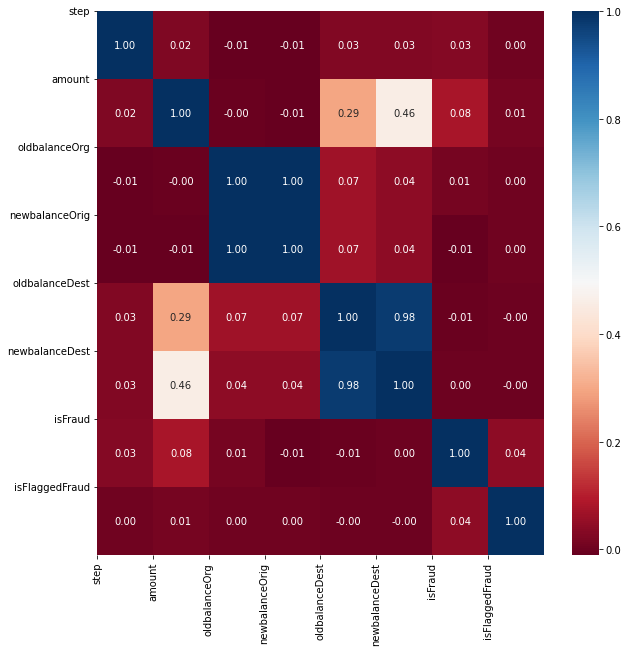

In [6]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, cmap='RdBu', annot=True, fmt=".2f")
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

###As the Correlation between newbalanceDest and oldbalanceDest is high, leading to multi-collinearity, we need to drop one of the columns in feature selection.

<AxesSubplot:xlabel='isFraud', ylabel='step'>

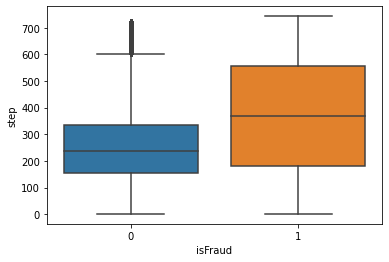

In [7]:
sns.boxplot(x=df.isFraud,y=df.step)

<AxesSubplot:xlabel='isFraud', ylabel='amount'>

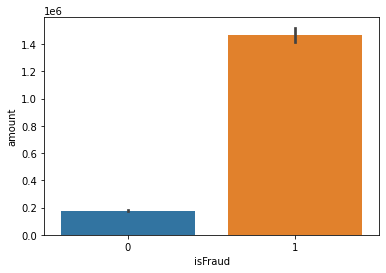

In [20]:
sns.barplot(x=df.isFraud,y=df.amount)

#Predictive Modelling

##Encoding Data

In [34]:
from sklearn.preprocessing import LabelEncoder,StandardScaler
data = df.copy()
data = data.drop(['nameOrig', 'nameDest', 'oldbalanceDest'], axis=1)

label_encoder = LabelEncoder()
data['type'] = label_encoder.fit_transform(data['type'])

##Splitting Data

In [35]:
X = data.drop(['isFraud'], axis=1)
y = data['isFraud']

In [36]:
y.value_counts() ###CHECK THIS VALUE COUNTS FORMATTING REQUIRED

0    6354407
1       8213
Name: isFraud, dtype: int64

##Balancing Data Using SMOTE

In [37]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X,y)

In [38]:
y_sm.value_counts()

0    6354407
1    6354407
Name: isFraud, dtype: int64

Now the Data is Balanced.

##Scaling Data

In [43]:
scaler = StandardScaler()
X[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'newbalanceDest']] = scaler.fit_transform(X[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'newbalanceDest']])

##Splitting Data into Train and Test

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm,y_sm,test_size=.2, random_state=42)

##Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [46]:
y_pred = model.predict(X_test)

#Confusion Matrix

In [47]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1179744   91093]
 [ 140208 1130718]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91   1270837
           1       0.93      0.89      0.91   1270926

    accuracy                           0.91   2541763
   macro avg       0.91      0.91      0.91   2541763
weighted avg       0.91      0.91      0.91   2541763



#AUROC Graph

C:\Users\shubh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\shubh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


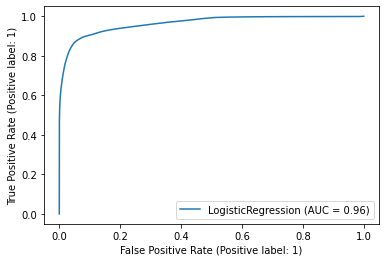

In [48]:
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score, confusion_matrix, f1_score

confusion_matrix(y_test,y_pred)
f1_score(y_test,model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=2)
plot_roc_curve(model, X_test, y_test)